#### IMPORTANT
Ensure you are utilizing 64-bit REFPROP with 64-bit python. If using the free version of REFPROP (MINI-REFPROP), please use 32-bit python and make changes to match the location where MINI-REFPROP is installed and make changes to the REFPROPFunctionLibrary function to read the REFPROP.DLL file.

Information on REFPROP and functions can be found here: https://buildmedia.readthedocs.org/media/pdf/refprop-docs/latest/refprop-docs.pdf

In [1]:
### IMPORT PACKAGES & FUNCTIONS

In [2]:
# Dictate the environment's loctaion of REFPROP
import os
os.environ['RPPREFIX'] = r'C:/Program Files (x86)/REFPROP'

In [3]:
# Import the main class from the Python library
from ctREFPROP.ctREFPROP import REFPROPFunctionLibrary

# Imports from conda-installable packages
import pandas as pd

# Import numpy
import numpy as np

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Import Math for common values such as PI
import math


In [4]:
# Instantiate the library, and use the environment variable to explicitly state which path we want to use.
# As mentioned above, this will be changed to call the correct REFPROP functions to be used
# with MINI-REFPROP and 32-bit python.
# If using MINI-REFPROP and 32-bit python please make the following changes
# RP = REFPROPFunctionLibrary('C:/Program FIles (x86)/MINI-REFPROP\\REFPROP.DLL')
RP = REFPROPFunctionLibrary(os.environ['RPPREFIX'])

In [5]:
# This will call which root directory that will be used for the program. 
RP.SETPATHdll(os.environ['RPPREFIX'])

In [6]:
# Get the unit system we want to use (Mass base SI gives units in
# K, Pa, kg, m, N, J, W, and s)
MASS_BASE_SI = RP.GETENUMdll(0, "MASS BASE SI").iEnum

In [7]:
### sCO2 Loop Calculations

In [8]:
#### System Parameters

In [9]:
# Tube inner diameter and outer diameter
Tube_OD = 0.50 # [inch]
Tube_Thick = 0.049 # [inch]
Tube_ID = Tube_OD - 2 * Tube_Thick # inch

Tube_OD = Tube_OD * 0.0254 # [Convert inches to meters]
Tube_ID = Tube_ID * 0.0254 # [Convert inches to meters]

# Mass flow rate of sCO2
m_dot = 0.2 # [kg/s]

In [10]:
#### Outlet of Compressor (State  1)

In [11]:
# Temperature will be compared at end of script
T1 = 80 # [C]
P1 = 2500 # [psia]

T1 = T1 + 273.15 # Convert C to Kelvin
P1 = P1 * 6894.8 # convert psia to Pa

print("Pressure at Outlet of Compressor =", P1/6894.8, "psia")
print("Temperature at Outlet of Compressor =" , (T1 - 273.15) * (9/5) + 32, "F")

Pressure at Outlet of Compressor = 2500.0 psia
Temperature at Outlet of Compressor = 176.0 F


In [12]:
# Obtain fluid properties from the pressure and temperature outlined above
State_1 = RP.REFPROPdll("CO2","PT","D;V;H;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P1,T1,[1.0])

# Outputs will be placed into data frame for organization
State_1 = pd.DataFrame(State_1.Output[0:9],
            index = ['Density [kg/m^3]', 'Volume [m^3/kg]', 'Enthalpy [J/kg]', 'Entropy [J/kg K]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 1'])

# Display the data frame
State_1

,State 1
Density [kg/m^3],514.132818
Volume [m^3/kg],0.001945
Enthalpy [J/kg],392720.612298
Entropy [J/kg K],1557.860350
CP/CV,3.090517
Speed of Sound,300.173453
Thermal Cond. [W/(mK)],0.058033
Viscosity [Pa-s],0.000038
Prandtl,1.895960


In [13]:
#### Pressure drop towards Heat Source

In [14]:
# Find Velocity, Reynolds Number, and darcy friction factor (assuming smooth pipe)
Velocity = 4 * m_dot * State_1.loc['Volume [m^3/kg]','State 1'] / (math.pi * Tube_ID**2)
Reynolds = State_1.loc['Density [kg/m^3]','State 1'] * Velocity * Tube_ID / State_1.loc['Viscosity [Pa-s]','State 1']
Darcy_f = (0.79 * math.log(Reynolds) - 1.64)**(-2)

In [15]:
# Using Estimated Length of Tubing connecting compressor and Heat Source, 
# find the amount of pressure drop caused by fanno flow
Length = 4 # [meters]

# Force acted on the wall of tube
Force = math.pi * Tube_ID * Darcy_f * State_1.loc['Density [kg/m^3]','State 1'] * (Velocity**2) * Length / 8 

# Dimensionless Friction factor
f_dim = 4 * Force / (P1 * math.pi * Tube_ID**2) 

# Inlet Mach Number of length of tubing
Mach_inlet = Velocity / State_1.loc['Speed of Sound','State 1']

# Formulation used to calculate Pressure drop (found in Adv. Fluid Mechanics Textbook)
A_eq = ((Mach_inlet**2) * (1 + ((State_1.loc['CP/CV','State 1'] - 1) / 2) * (Mach_inlet**2))) \
        / ((1 + State_1.loc['CP/CV','State 1'] * (Mach_inlet**2) - f_dim)**2)

# Find the positive outcome to the biquadratic Mach number
Mach_outlet_1 = math.sqrt((-1 * (1 - 2 * A_eq * State_1.loc['CP/CV','State 1'])\
                          + ((1 - 2 * A_eq * (State_1.loc['CP/CV','State 1'] + 1))**0.5))\
                         / ((State_1.loc['CP/CV','State 1'] - 1) - 2 * A_eq * State_1.loc['CP/CV','State 1']**2))

# Find Outlet pressure caused by fanno flow (frictional loss)
P2 = P1 * (1 + State_1.loc['CP/CV','State 1'] * (Mach_inlet**2) - f_dim) / (1 + State_1.loc['CP/CV','State 1']\
                                                                           * (Mach_outlet_1**2))

print("Pressure at Inlet of Heat Source =", round(P2/6894.8 , 3), "psia")

Pressure at Inlet of Heat Source = 2495.866 psia


In [16]:
# Find the enthalpy at the inlet of the Heat Source
Enth_2 = (State_1.loc['Enthalpy [J/kg]','State 1'] * (1 + ((State_1.loc['CP/CV','State 1'] - 1) / 2) * Mach_inlet**2)) / \
            (1 + ((State_1.loc['CP/CV','State 1'] - 1) / 2) * (Mach_outlet_1**2))

Enth_2 # [J/kg]

392720.27160116227

In [17]:
#### Inlet of Heat Source (State 2)

In [18]:
#Pressure and temperature of fluid at inlet of Heat Source
P2 = P2


# Tube ID (using 1" OD Tubes)
Tube_HS_ID = .81 * 0.0254 # convert inches to meters

# Obtain fluid properties from the pressure and temperature outlined above
State_2 = RP.REFPROPdll("CO2","PH","T;D;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P2,Enth_2,[1.0])

# Outputs will be placed into data frame for organization
State_2 = pd.DataFrame(State_2.Output[0:9],
            index = ['Temperature [K]', 'Density [kg/m^3]', 'Volume [m^3/kg]', 'Entropy [J/kg K]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 2'])

# Display the data frame
State_2

,State 2
Temperature [K],353.075363
Density [kg/m^3],513.680363
Volume [m^3/kg],0.001947
Entropy [J/kg K],1558.016457
CP/CV,3.094251
Speed of Sound,299.854241
Thermal Cond. [W/(mK)],0.057999
Viscosity [Pa-s],0.000038
Prandtl,1.897651


In [19]:
# Find Velocity, Reynolds Number, and darcy friction factor (assuming smooth pipe)
Velocity = 4 * m_dot * State_2.loc['Volume [m^3/kg]','State 2'] / (math.pi * Tube_HS_ID**2)
Reynolds = State_2.loc['Density [kg/m^3]','State 2'] * Velocity * Tube_HS_ID / State_2.loc['Viscosity [Pa-s]','State 2']
Darcy_f = (0.79 * math.log(Reynolds) - 1.64)**(-2)

In [20]:
# Find the amount of Heat Supplied by Heat Tapes
Power = 1245 # [W]
Voltage_1 = 240 # [VAC]
Res = Voltage_1**2 / Power # Resistance per tape
P_act = 208**2 / Res # Actual power into per tape
Voltage_loss = 1.732 * 12.9 * 65 * 67 / 41740 # Voltage lost [%]
V_new = 208 - (208 * Voltage_loss/100) # Voltage that can be supplied to tapes after loss
P_new = V_new**2 / Res # New Power

Q_total_1 = P_new * 18 # 18 Heat Tapes used, Total heat developed

# 1 Heat tape is different with a different power
Power_2 = 940 # [W]
Voltage_2 = 240 # [VAC]
Res_2 = Voltage_2**2 / Power_2 # Resistance per tape
P_act_2 = 208**2 / Res_2 # Actual power into per tape
V_new_2 = 208 - (208 * Voltage_loss/100) # Voltage that can be supplied to tapes after loss
P_new_2 = V_new_2**2 / Res_2 # New Power

Q_total = Q_total_1 + P_new_2 # Total heat added to system

# Find the new heat flux of each tape
q_flux_1 = 13 # [W/in^2] Original heat flux per tape
Q_orig_1 = 1245 * 18 # Original heat provided by tapes
A_orig_1 = Q_orig_1 / q_flux_1 # [in^2]

q_flux_new = Q_total_1 / A_orig_1 # This is valid for all tapes

Q_total

16730.274708409575

In [21]:
# Using Estimated Length of Tubing used by Heat Source 
# find the amount of pressure drop caused by fanno flow and Heat addition
Length = 17.37 # [meters]

# Force acted on the wall of tube
Force = math.pi * Tube_HS_ID * Darcy_f * State_2.loc['Density [kg/m^3]','State 2'] * (Velocity**2) * Length / 8 

# Dimensionless Friction factor
f_dim = 4 * Force / (P2 * math.pi * Tube_HS_ID**2) 

# Heat Added into system (kW)
# Max Heat Possible is 16730 W
Q = 2.8 # [kW]

# Dimensionless heating factor
q_dim = Q * 1000 / (m_dot * Enth_2)

# Inlet Mach Number of length of tubing
Mach_inlet = Velocity / State_2.loc['Speed of Sound','State 2']

# Formulation used to calculate Pressure drop (found in Adv. Fluid Mechanics Textbook)
A_eq = ((Mach_inlet**2) * (1 + ((State_2.loc['CP/CV','State 2'] - 1) / 2) * (Mach_inlet**2) + q_dim)) \
        / ((1 + State_2.loc['CP/CV','State 2'] * (Mach_inlet**2) - f_dim)**2)

# Find the positive outcome to the biquadratic Mach number
Mach_outlet_1 = math.sqrt((-1 * (1 - 2 * A_eq * State_2.loc['CP/CV','State 2'])\
                          + ((1 - 2 * A_eq * (State_2.loc['CP/CV','State 2'] + 1))**0.5))\
                         / ((State_2.loc['CP/CV','State 2'] - 1) - 2 * A_eq * State_2.loc['CP/CV','State 2']**2))

# Find Outlet pressure caused by fanno flow (frictional loss)
P3 = P2 * (1 + State_2.loc['CP/CV','State 2'] * (Mach_inlet**2) - f_dim) / (1 + State_2.loc['CP/CV','State 2']\
                                                                           * (Mach_outlet_1**2))



In [22]:
# Find the enthalpy at the outlet of the Heat source
Enth_3 = (Enth_2 * (1 + ((State_2.loc['CP/CV','State 2'] - 1) / 2) * Mach_inlet**2 + q_dim)) / \
            (1 + ((State_2.loc['CP/CV','State 2'] - 1) / 2) * (Mach_outlet_1**2))

Enth_3 # [J/kg]

406719.81305289984

In [23]:
# Find the surface temperature of the tubing with constant heat flux
# 1 Heat Tape covers approximately 3 feet

T_HS_sCO2 = []
T_Sur_HS = []
L_x = []

P_new = P2
Enth_new = Enth_2

for x in range(0,101):
    P_old = P_new # Looping Pressure
    Enth_old = Enth_new # Looping Enthalpy
    
    # Obtain Properties of sCO2
    sCO2_HS_Calc = RP.REFPROPdll("CO2","PH","T;D;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P_old,Enth_old,[1.0])
    
    sCO2_HS_Calc = pd.DataFrame(sCO2_HS_Calc.Output[0:9],
                index = ['Temperature [K]', 'Density [kg/m^3]', 'Volume [m^3/kg]', 'Entropy [J/kg K]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
                columns = ['sCO2 HS'])
    
    T_HS_sCO2.append(sCO2_HS_Calc.loc['Temperature [K]','sCO2 HS'])
    
    # Find Velocity, Reynolds Number, and darcy friction factor (assuming smooth pipe)
    Velocity = 4 * m_dot * sCO2_HS_Calc.loc['Volume [m^3/kg]','sCO2 HS'] / (math.pi * Tube_HS_ID**2)
    Reynolds = sCO2_HS_Calc.loc['Density [kg/m^3]','sCO2 HS'] * Velocity * Tube_HS_ID / sCO2_HS_Calc.loc['Viscosity [Pa-s]','sCO2 HS']
    Darcy_f = (0.79 * math.log(Reynolds) - 1.64)**(-2)
    Nus = 0.0243 * Reynolds**(4/5) * (sCO2_HS_Calc.loc['Prandtl', 'sCO2 HS'])**(0.4)
    h_sCO2_HS = Nus * (sCO2_HS_Calc.loc['Thermal Cond. [W/(mK)]', 'sCO2 HS']) / Tube_HS_ID
    
     # Newton's Law of Cooling
    Sur_T = (q_flux_new / .00064516) / h_sCO2_HS + sCO2_HS_Calc.loc['Temperature [K]', 'sCO2 HS']
    T_Sur_HS.append(Sur_T)
    
    # Force acted on the wall of tube
    Force = math.pi * Tube_HS_ID * Darcy_f * sCO2_HS_Calc.loc['Density [kg/m^3]','sCO2 HS'] * (Velocity**2) * Length*(x/100) / 8 

    # Dimensionless Friction factor
    f_dim = 4 * Force / (P2 * math.pi * Tube_HS_ID**2) 

    # Heat Added into system (kW)
    Q = 2800*(x/100)/1000

    # Dimensionless heating factor
    q_dim = Q * 1000 / (m_dot * Enth_2)

    # Inlet Mach Number of length of tubing
    Mach_inlet = Velocity / sCO2_HS_Calc.loc['Speed of Sound','sCO2 HS']

    # Formulation used to calculate Pressure drop (found in Adv. Fluid Mechanics Textbook)
    A_eq = ((Mach_inlet**2) * (1 + ((sCO2_HS_Calc.loc['CP/CV','sCO2 HS'] - 1) / 2) * (Mach_inlet**2) + q_dim)) \
            / ((1 + sCO2_HS_Calc.loc['CP/CV','sCO2 HS'] * (Mach_inlet**2) - f_dim)**2)

    # Find the positive outcome to the biquadratic Mach number
    Mach_outlet_1 = math.sqrt((-1 * (1 - 2 * A_eq * sCO2_HS_Calc.loc['CP/CV','sCO2 HS'])\
                              + ((1 - 2 * A_eq * (sCO2_HS_Calc.loc['CP/CV','sCO2 HS'] + 1))**0.5))\
                             / ((sCO2_HS_Calc.loc['CP/CV','sCO2 HS'] - 1) - 2 * A_eq * sCO2_HS_Calc.loc['CP/CV','sCO2 HS']**2))

    # Find Outlet pressure caused by fanno flow (frictional loss)
    P_new = P2 * (1 + sCO2_HS_Calc.loc['CP/CV','sCO2 HS'] * (Mach_inlet**2) - f_dim) / (1 + sCO2_HS_Calc.loc['CP/CV','sCO2 HS']\
                                                                               * (Mach_outlet_1**2))

    Enth_new = (Enth_2 * (1 + ((sCO2_HS_Calc.loc['CP/CV','sCO2 HS'] - 1) / 2) * Mach_inlet**2 + q_dim)) / \
                (1 + ((sCO2_HS_Calc.loc['CP/CV','sCO2 HS'] - 1) / 2) * (Mach_outlet_1**2))
    
    L_x.append(Length*(x/100))


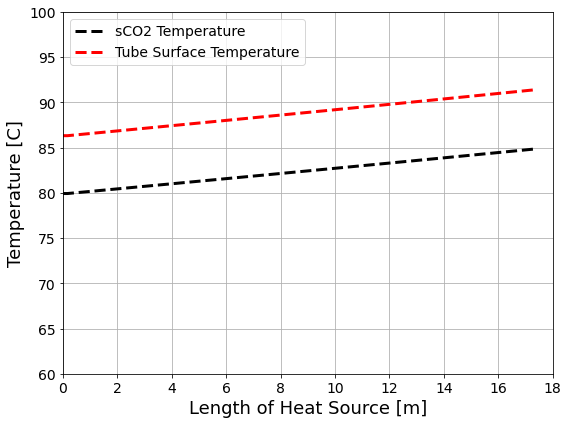

In [24]:
# Plot Surface Temperature 
T_HS_sCO2 = np.array(T_HS_sCO2) - 273.15
T_Sur_HS = np.array(T_Sur_HS) - 273.15

plt.figure(figsize=(8,6), tight_layout=True)

plt.plot(L_x, T_HS_sCO2, 'k--', linewidth = 3 , label = "sCO2 Temperature" )
plt.plot(L_x, T_Sur_HS, '--',color = 'red' ,linewidth = 3 , label = "Tube Surface Temperature")
plt.grid(True)
plt.axis([0,18,60,100])
plt.xlabel('Length of Heat Source [m]', fontsize = 18)
plt.ylabel('Temperature [C]', fontsize = 18)
plt.legend(loc = "upper left" , fontsize=14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

#plt.savefig('Heat_Source_Surface_Temp.png',bbox_inches='tight')
plt.show()

In [25]:
# Small Section of Piping that is a part of the heat source but not heated

Length = 1.8288 # [meters]

# Force acted on the wall of tube
Force = math.pi * Tube_HS_ID * Darcy_f * State_2.loc['Density [kg/m^3]','State 2'] * (Velocity**2) * Length / 8 

# Dimensionless Friction factor
f_dim = 4 * Force / (P2 * math.pi * Tube_HS_ID**2) 

# Heat Added into system (kW)
Q = 0 # [kW]

# Dimensionless heating factor
q_dim = Q * 1000 / (m_dot * Enth_2)

# Inlet Mach Number of length of tubing
Mach_inlet = Velocity / State_2.loc['Speed of Sound','State 2']

# Formulation used to calculate Pressure drop (found in Adv. Fluid Mechanics Textbook)
A_eq = ((Mach_inlet**2) * (1 + ((State_2.loc['CP/CV','State 2'] - 1) / 2) * (Mach_inlet**2) + q_dim)) \
        / ((1 + State_2.loc['CP/CV','State 2'] * (Mach_inlet**2) - f_dim)**2)

# Find the positive outcome to the biquadratic Mach number
Mach_outlet_1 = math.sqrt((-1 * (1 - 2 * A_eq * State_2.loc['CP/CV','State 2'])\
                          + ((1 - 2 * A_eq * (State_2.loc['CP/CV','State 2'] + 1))**0.5))\
                         / ((State_2.loc['CP/CV','State 2'] - 1) - 2 * A_eq * State_2.loc['CP/CV','State 2']**2))

# Find Outlet pressure caused by fanno flow (frictional loss)
P3 = P3 * (1 + State_2.loc['CP/CV','State 2'] * (Mach_inlet**2) - f_dim) / (1 + State_2.loc['CP/CV','State 2']\
                                                                           * (Mach_outlet_1**2))

print("Pressure at Outlet of Heat Source =", round(P3/6894.8 , 3), "psia")

Pressure at Outlet of Heat Source = 2495.174 psia


In [26]:
# Find the enthalpy at the outlet of the Heat source
Enth_3 = (Enth_3 * (1 + ((State_2.loc['CP/CV','State 2'] - 1) / 2) * Mach_inlet**2 + q_dim)) / \
            (1 + ((State_2.loc['CP/CV','State 2'] - 1) / 2) * (Mach_outlet_1**2))

Enth_3 # [J/kg]

406719.81261820224

In [27]:
#### Outlet of Heat Source (State 3)

In [28]:
# Using the new Pressure and enthalpy find the states of the fluid at the outlet of Heat Source

State_3 = RP.REFPROPdll("CO2","PH","T;D;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P3,Enth_3,[1.0])

# Outputs will be placed into data frame for organization
State_3 = pd.DataFrame(State_3.Output[0:9],
            index = ['Temperature [K]', 'Density [kg/m^3]', 'Volume [m^3/kg]', 'Entropy [J/kg K]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 3'])

# Display the data frame
State_3

,State 3
Temperature [K],358.057024
Density [kg/m^3],480.106322
Volume [m^3/kg],0.002083
Entropy [J/kg K],1597.418838
CP/CV,2.970096
Speed of Sound,293.857093
Thermal Cond. [W/(mK)],0.055112
Viscosity [Pa-s],0.000036
Prandtl,1.783507


In [29]:
# Add enthalpy to the data frame
State_2.loc['Enthalpy [J/kg]', 'State 2'] = Enth_2
State_3.loc['Enthalpy [J/kg]', 'State 3'] = Enth_3

In [30]:
# Find Velocity, Reynolds Number, and darcy friction factor (assuming smooth pipe)
Velocity = 4 * m_dot * State_3.loc['Volume [m^3/kg]','State 3'] / (math.pi * Tube_ID**2)
Reynolds = State_3.loc['Density [kg/m^3]','State 3'] * Velocity * Tube_ID / State_3.loc['Viscosity [Pa-s]','State 3']
Darcy_f = (0.79 * math.log(Reynolds) - 1.64)**(-2)

In [31]:
# Using Estimated Length of Tubing connecting Heat Source and Engine 
# find the amount of pressure drop caused by fanno flow
Length = 2.5 # [meters]

# Force acted on the wall of tube
Force = math.pi * Tube_ID * Darcy_f * State_3.loc['Density [kg/m^3]','State 3'] * (Velocity**2) * Length / 8 

# Dimensionless Friction factor
f_dim = 4 * Force / (P3 * math.pi * Tube_ID**2) 

# Heat Added into system (kW)
Q = 0

# Dimensionless heating factor
q_dim = Q * 1000 / (m_dot * State_3.loc['Enthalpy [J/kg]','State 3'])

# Inlet Mach Number of length of tubing
Mach_inlet = Velocity / State_3.loc['Speed of Sound','State 3']

# Formulation used to calculate Pressure drop (found in Adv. Fluid Mechanics Textbook)
A_eq = ((Mach_inlet**2) * (1 + ((State_3.loc['CP/CV','State 3'] - 1) / 2) * (Mach_inlet**2) + q_dim)) \
        / ((1 + State_3.loc['CP/CV','State 3'] * (Mach_inlet**2) - f_dim)**2)

# Find the positive outcome to the biquadratic Mach number
Mach_outlet_1 = math.sqrt((-1 * (1 - 2 * A_eq * State_3.loc['CP/CV','State 3'])\
                          + ((1 - 2 * A_eq * (State_3.loc['CP/CV','State 3'] + 1))**0.5))\
                         / ((State_3.loc['CP/CV','State 3'] - 1) - 2 * A_eq * State_3.loc['CP/CV','State 3']**2))

# Find Outlet pressure caused by fanno flow (frictional loss)
P4 = P3 * (1 + State_3.loc['CP/CV','State 3'] * (Mach_inlet**2) - f_dim) / (1 + State_3.loc['CP/CV','State 3']\
                                                                           * (Mach_outlet_1**2))

print("Pressure at Inlet of Engine =", round(P4/6894.8 , 3), "psia")

Pressure at Inlet of Engine = 2492.439 psia


In [32]:
# Find the enthalpy at the inlet of the Engine
Enth_4 = (State_3.loc['Enthalpy [J/kg]','State 3'] * (1 + ((State_3.loc['CP/CV','State 3'] - 1) / 2) * Mach_inlet**2 + q_dim)) / \
            (1 + ((State_3.loc['CP/CV','State 3'] - 1) / 2) * (Mach_outlet_1**2))

Enth_4 # [J/kg]

406719.5491055624

In [33]:
##### Check order of states before continuing

In [34]:
# Combine the data frames into one data frame for ease of use
sCO2_States = pd.concat([State_1, State_2, State_3], axis =1)

# Display the data frame to ensure proper layout
sCO2_States

,State 1,State 2,State 3
Density [kg/m^3],514.132818,513.680363,480.106322
Volume [m^3/kg],0.001945,0.001947,0.002083
Enthalpy [J/kg],392720.612298,392720.271601,406719.812618
Entropy [J/kg K],1557.860350,1558.016457,1597.418838
CP/CV,3.090517,3.094251,2.970096
Speed of Sound,300.173453,299.854241,293.857093
Thermal Cond. [W/(mK)],0.058033,0.057999,0.055112
Viscosity [Pa-s],0.000038,0.000038,0.000036
Prandtl,1.895960,1.897651,1.783507
Temperature [K],NaN,353.075363,358.057024


In [35]:
# Fill in the Missing data
sCO2_States.loc['Temperature [K]', 'State 1'] = T1
sCO2_States.loc['Pressure [Pa]', 'State 1'] = P1
sCO2_States.loc['Pressure [Pa]', 'State 2'] = P2
sCO2_States.loc['Pressure [Pa]', 'State 3'] = P3

# Display Data Frame
sCO2_States

,State 1,State 2,State 3
Density [kg/m^3],5.141328e+02,5.136804e+02,4.801063e+02
Volume [m^3/kg],1.945023e-03,1.946736e-03,2.082872e-03
Enthalpy [J/kg],3.927206e+05,3.927203e+05,4.067198e+05
Entropy [J/kg K],1.557860e+03,1.558016e+03,1.597419e+03
CP/CV,3.090517e+00,3.094251e+00,2.970096e+00
Speed of Sound,3.001735e+02,2.998542e+02,2.938571e+02
Thermal Cond. [W/(mK)],5.803275e-02,5.799875e-02,5.511248e-02
Viscosity [Pa-s],3.842258e-05,3.838157e-05,3.595914e-05
Prandtl,1.895960e+00,1.897651e+00,1.783507e+00
Temperature [K],3.531500e+02,3.530754e+02,3.580570e+02


In [36]:
# Reorder the Data Frame
sCO2_States = sCO2_States.reindex(["Pressure [Pa]", "Temperature [K]", 'Density [kg/m^3]', 'Volume [m^3/kg]', 'Enthalpy [J/kg]',
                     'Entropy [J/kg K]', 'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 
                     'Prandtl' ])

In [37]:
#### Inlet of Engine (State 4)

In [38]:
# Using the new Pressure and enthalpy find the states of the fluid at the Inlet of Engine

State_4 = RP.REFPROPdll("CO2","PH","T;D;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P4,Enth_4,[1.0])

# Outputs will be placed into data frame for organization
State_4 = pd.DataFrame(State_4.Output[0:9],
            index = ['Temperature [K]', 'Density [kg/m^3]', 'Volume [m^3/kg]', 'Entropy [J/kg K]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 4'])

# Display the data frame
State_4

,State 4
Temperature [K],358.003349
Density [kg/m^3],479.797321
Volume [m^3/kg],0.002084
Entropy [J/kg K],1597.527844
CP/CV,2.972079
Speed of Sound,293.664087
Thermal Cond. [W/(mK)],0.055089
Viscosity [Pa-s],0.000036
Prandtl,1.784312


In [39]:
# Engine Parameters
mass_cylinder = State_4.loc['Density [kg/m^3]', 'State 4'] * .000308276
State_5_den = mass_cylinder / .000454574

# With Isentropic expansion
State_5_entr = State_4.loc['Entropy [J/kg K]', 'State 4']

In [40]:
#### Outlet of Engine (State 5)

In [41]:
# Using the new density and entropy find the states of the fluid at the Outlet of Engine

State_5_isen = RP.REFPROPdll("CO2","DS","P;T;V;H;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,State_5_den,State_5_entr,[1.0])

# Outputs will be placed into data frame for organization
State_5_isen = pd.DataFrame(State_5_isen.Output[0:9],
            index = ['Pressure [Pa]', 'Temperature [K]', 'Volume [m^3/kg]', 'Enthalpy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 5 Isentropic'])

# Display the data frame
State_5_isen

,State 5 Isentropic
Pressure [Pa],8.129972e+06
Temperature [K],3.112369e+02
Volume [m^3/kg],3.073315e-03
Enthalpy [J/kg],3.845180e+05
CP/CV,7.516356e+00
Speed of Sound,1.970232e+02
Thermal Cond. [W/(mK)],5.464764e-02
Viscosity [Pa-s],2.397481e-05
Prandtl,3.704185e+00


In [42]:
# Combine the data frames into one data frame for ease of use
sCO2_States = pd.concat([sCO2_States, State_4, State_5_isen], axis =1)

# Fill in the Missing data
sCO2_States.loc['Pressure [Pa]', 'State 4'] = P4
sCO2_States.loc['Enthalpy [J/kg]', 'State 4'] = Enth_4
sCO2_States.loc['Density [kg/m^3]', 'State 5 Isentropic'] = State_5_den
sCO2_States.loc['Entropy [J/kg K]', 'State 5 Isentropic'] = State_5_entr

# Display the data frame
sCO2_States

,State 1,State 2,State 3,State 4,State 5 Isentropic
Pressure [Pa],1.723700e+07,1.720850e+07,1.720373e+07,1.718487e+07,8.129972e+06
Temperature [K],3.531500e+02,3.530754e+02,3.580570e+02,3.580033e+02,3.112369e+02
Density [kg/m^3],5.141328e+02,5.136804e+02,4.801063e+02,4.797973e+02,3.253816e+02
Volume [m^3/kg],1.945023e-03,1.946736e-03,2.082872e-03,2.084213e-03,3.073315e-03
Enthalpy [J/kg],3.927206e+05,3.927203e+05,4.067198e+05,4.067195e+05,3.845180e+05
Entropy [J/kg K],1.557860e+03,1.558016e+03,1.597419e+03,1.597528e+03,1.597528e+03
CP/CV,3.090517e+00,3.094251e+00,2.970096e+00,2.972079e+00,7.516356e+00
Speed of Sound,3.001735e+02,2.998542e+02,2.938571e+02,2.936641e+02,1.970232e+02
Thermal Cond. [W/(mK)],5.803275e-02,5.799875e-02,5.511248e-02,5.508894e-02,5.464764e-02
Viscosity [Pa-s],3.842258e-05,3.838157e-05,3.595914e-05,3.593317e-05,2.397481e-05


In [43]:
# Account for Issentropic Efficiency
Isen_eff = .7
State_5_enth_new = sCO2_States.loc['Enthalpy [J/kg]', 'State 4'] - (Isen_eff * (sCO2_States.loc['Enthalpy [J/kg]', 'State 4'] - sCO2_States.loc['Enthalpy [J/kg]', 'State 5 Isentropic']))

# Using Pressure and enthalpy find the states of the fluid at the Outlet of Engine

State_5 = RP.REFPROPdll("CO2","DH","P;T;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,sCO2_States.loc['Density [kg/m^3]', 'State 5 Isentropic'],State_5_enth_new,[1.0])

# Outputs will be placed into data frame for organization
State_5 = pd.DataFrame(State_5.Output[0:9],
            index = ['Pressure [Pa]','Temperature [K]', 'Volume [m^3/kg]', 'Entropy [J/kg K]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 5'])

# Display the data frame
State_5

,State 5
Pressure [Pa],8.652334e+06
Temperature [K],3.158823e+02
Volume [m^3/kg],3.073315e-03
Entropy [J/kg K],1.613651e+03
CP/CV,5.914264e+00
Speed of Sound,2.056311e+02
Thermal Cond. [W/(mK)],5.050080e-02
Viscosity [Pa-s],2.422770e-05
Prandtl,3.002399e+00


In [44]:
# Combine the data frames into one data frame for ease of use
sCO2_States = pd.concat([sCO2_States, State_5], axis =1)

# Fill in the Missing data
sCO2_States.loc['Density [kg/m^3]', 'State 5'] = sCO2_States.loc['Density [kg/m^3]', 'State 5 Isentropic']
sCO2_States.loc['Enthalpy [J/kg]', 'State 5'] = State_5_enth_new

# Display the data frame
sCO2_States

,State 1,State 2,State 3,State 4,State 5 Isentropic,State 5
Pressure [Pa],1.723700e+07,1.720850e+07,1.720373e+07,1.718487e+07,8.129972e+06,8.652334e+06
Temperature [K],3.531500e+02,3.530754e+02,3.580570e+02,3.580033e+02,3.112369e+02,3.158823e+02
Density [kg/m^3],5.141328e+02,5.136804e+02,4.801063e+02,4.797973e+02,3.253816e+02,3.253816e+02
Volume [m^3/kg],1.945023e-03,1.946736e-03,2.082872e-03,2.084213e-03,3.073315e-03,3.073315e-03
Enthalpy [J/kg],3.927206e+05,3.927203e+05,4.067198e+05,4.067195e+05,3.845180e+05,3.911784e+05
Entropy [J/kg K],1.557860e+03,1.558016e+03,1.597419e+03,1.597528e+03,1.597528e+03,1.613651e+03
CP/CV,3.090517e+00,3.094251e+00,2.970096e+00,2.972079e+00,7.516356e+00,5.914264e+00
Speed of Sound,3.001735e+02,2.998542e+02,2.938571e+02,2.936641e+02,1.970232e+02,2.056311e+02
Thermal Cond. [W/(mK)],5.803275e-02,5.799875e-02,5.511248e-02,5.508894e-02,5.464764e-02,5.050080e-02
Viscosity [Pa-s],3.842258e-05,3.838157e-05,3.595914e-05,3.593317e-05,2.397481e-05,2.422770e-05


In [45]:
# Work Analysis of Engine
Isen_Work = m_dot * (sCO2_States.loc['Enthalpy [J/kg]','State 4'] - sCO2_States.loc['Enthalpy [J/kg]','State 5 Isentropic'])
Act_Work = m_dot * (sCO2_States.loc['Enthalpy [J/kg]','State 4'] - sCO2_States.loc['Enthalpy [J/kg]','State 5'])

print("Isentropic Work Produced =", round(Isen_Work/1000 , 4), "kW")
print("Actual Work Produced =", round(Act_Work/1000 , 4), "kW")
print("Difference in Work=", round((Isen_Work - Act_Work)/1000 , 4), "kW")

Isentropic Work Produced = 4.4403 kW
Actual Work Produced = 3.1082 kW
Difference in Work= 1.3321 kW


In [46]:
# Find Velocity, Reynolds Number, and darcy friction factor (assuming smooth pipe)
Velocity = 4 * m_dot * sCO2_States.loc['Volume [m^3/kg]','State 5'] / (math.pi * Tube_ID**2)
Reynolds = sCO2_States.loc['Density [kg/m^3]','State 5'] * Velocity * Tube_ID / sCO2_States.loc['Viscosity [Pa-s]','State 5']
Darcy_f = (0.79 * math.log(Reynolds) - 1.64)**(-2)

In [47]:
# Using Estimated Length of Tubing connecting Engine and Heat Exchanger 
# find the amount of pressure drop caused by fanno flow
Length = 12.3 # [meters]

# Force acted on the wall of tube
Force = math.pi * Tube_ID * Darcy_f * sCO2_States.loc['Density [kg/m^3]','State 5'] * (Velocity**2) * Length / 8 

# Dimensionless Friction factor
f_dim = 4 * Force / (sCO2_States.loc['Pressure [Pa]','State 5'] * math.pi * Tube_ID**2) 

# Heat Added into system (kW)
Q = 0

# Dimensionless heating factor
q_dim = Q * 1000 / (m_dot * sCO2_States.loc['Enthalpy [J/kg]','State 5'])

# Inlet Mach Number of length of tubing
Mach_inlet = Velocity / sCO2_States.loc['Speed of Sound','State 5']

# Formulation used to calculate Pressure drop (found in Adv. Fluid Mechanics Textbook)
A_eq = ((Mach_inlet**2) * (1 + ((sCO2_States.loc['CP/CV','State 5'] - 1) / 2) * (Mach_inlet**2) + q_dim)) \
        / ((1 + sCO2_States.loc['CP/CV','State 5'] * (Mach_inlet**2) - f_dim)**2)

# Find the positive outcome to the biquadratic Mach number
Mach_outlet_1 = math.sqrt((-1 * (1 - 2 * A_eq * sCO2_States.loc['CP/CV','State 5'])\
                          + ((1 - 2 * A_eq * (sCO2_States.loc['CP/CV','State 5'] + 1))**0.5))\
                         / ((sCO2_States.loc['CP/CV','State 5'] - 1) - 2 * A_eq * sCO2_States.loc['CP/CV','State 5']**2))

# Find Outlet pressure caused by fanno flow (frictional loss)
P6 = sCO2_States.loc['Pressure [Pa]','State 5'] * (1 + sCO2_States.loc['CP/CV','State 5'] * (Mach_inlet**2) - f_dim) / (1 + sCO2_States.loc['CP/CV','State 5']\
                                                                           * (Mach_outlet_1**2))

print("Pressure at Inlet of Heat Exchanger =", round(P6/6894.8 , 3), "psia")

Pressure at Inlet of Heat Exchanger = 1236.23 psia


In [48]:
# Find the enthalpy at the inlet of the Heat Exchanger
Enth_6 = (sCO2_States.loc['Enthalpy [J/kg]','State 5'] * (1 + ((sCO2_States.loc['CP/CV','State 5'] - 1) / 2) * Mach_inlet**2 + q_dim)) / \
            (1 + ((sCO2_States.loc['CP/CV','State 5'] - 1) / 2) * (Mach_outlet_1**2))

Enth_6 # [J/kg]

391139.71599271416

In [49]:
#### Inlet of Heat Exchanger (State 6)

In [50]:
# Using the new Pressure and enthalpy find the states of the fluid at the Inlet of Heat Exchanger

State_6 = RP.REFPROPdll("CO2","PH","T;D;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P6,Enth_6,[1.0])

# Outputs will be placed into data frame for organization
State_6 = pd.DataFrame(State_6.Output[0:9],
            index = ['Temperature [K]', 'Density [kg/m^3]', 'Volume [m^3/kg]', 'Entropy [J/kg K]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 6'])

# Display the data frame
State_6

,State 6
Temperature [K],314.972952
Density [kg/m^3],321.422109
Volume [m^3/kg],0.003111
Entropy [J/kg K],1614.790537
CP/CV,6.007384
Speed of Sound,204.305580
Thermal Cond. [W/(mK)],0.050473
Viscosity [Pa-s],0.000024
Prandtl,3.039418


In [51]:
# Add enthalpy and Pressure to Data frame
State_6.loc['Enthalpy [J/kg]', 'State 6'] = Enth_6
State_6.loc['Pressure [Pa]', 'State 6'] = P6

# Combine the data frames into one data frame for ease of use
sCO2_States = pd.concat([sCO2_States, State_6], axis =1)

# Display the data frame
sCO2_States

,State 1,State 2,State 3,State 4,State 5 Isentropic,State 5,State 6
Pressure [Pa],1.723700e+07,1.720850e+07,1.720373e+07,1.718487e+07,8.129972e+06,8.652334e+06,8.523559e+06
Temperature [K],3.531500e+02,3.530754e+02,3.580570e+02,3.580033e+02,3.112369e+02,3.158823e+02,3.149730e+02
Density [kg/m^3],5.141328e+02,5.136804e+02,4.801063e+02,4.797973e+02,3.253816e+02,3.253816e+02,3.214221e+02
Volume [m^3/kg],1.945023e-03,1.946736e-03,2.082872e-03,2.084213e-03,3.073315e-03,3.073315e-03,3.111174e-03
Enthalpy [J/kg],3.927206e+05,3.927203e+05,4.067198e+05,4.067195e+05,3.845180e+05,3.911784e+05,3.911397e+05
Entropy [J/kg K],1.557860e+03,1.558016e+03,1.597419e+03,1.597528e+03,1.597528e+03,1.613651e+03,1.614791e+03
CP/CV,3.090517e+00,3.094251e+00,2.970096e+00,2.972079e+00,7.516356e+00,5.914264e+00,6.007384e+00
Speed of Sound,3.001735e+02,2.998542e+02,2.938571e+02,2.936641e+02,1.970232e+02,2.056311e+02,2.043056e+02
Thermal Cond. [W/(mK)],5.803275e-02,5.799875e-02,5.511248e-02,5.508894e-02,5.464764e-02,5.050080e-02,5.047261e-02
Viscosity [Pa-s],3.842258e-05,3.838157e-05,3.595914e-05,3.593317e-05,2.397481e-05,2.422770e-05,2.398534e-05


In [52]:
# Find Velocity, Reynolds Number, and darcy friction factor (assuming smooth pipe)
Velocity = 4 * m_dot * sCO2_States.loc['Volume [m^3/kg]','State 6'] / (math.pi * Tube_ID**2)
Reynolds = sCO2_States.loc['Density [kg/m^3]','State 6'] * Velocity * Tube_ID / sCO2_States.loc['Viscosity [Pa-s]','State 6']
Darcy_f = (0.79 * math.log(Reynolds) - 1.64)**(-2)

In [53]:
# Using Estimated Length of Tubing used for Heat Exchanger
# find the amount of pressure drop caused by fanno flow & Heat loss
Length = 11.4 # [meters]

# Force acted on the wall of tube
Force = math.pi * Tube_ID * Darcy_f * sCO2_States.loc['Density [kg/m^3]','State 6'] * (Velocity**2) * Length / 8 

# Dimensionless Friction factor
f_dim = 4 * Force / (sCO2_States.loc['Pressure [Pa]','State 6'] * math.pi * Tube_ID**2) 

# Heat into system (kW)
Q = -8.85

# Dimensionless heating factor
q_dim = Q * 1000 / (m_dot * sCO2_States.loc['Enthalpy [J/kg]','State 6'])

# Inlet Mach Number of length of tubing
Mach_inlet = Velocity / sCO2_States.loc['Speed of Sound','State 6']

# Formulation used to calculate Pressure drop (found in Adv. Fluid Mechanics Textbook)
A_eq = ((Mach_inlet**2) * (1 + ((sCO2_States.loc['CP/CV','State 6'] - 1) / 2) * (Mach_inlet**2) + q_dim)) \
        / ((1 + sCO2_States.loc['CP/CV','State 6'] * (Mach_inlet**2) - f_dim)**2)

# Find the positive outcome to the biquadratic Mach number
Mach_outlet_1 = math.sqrt((-1 * (1 - 2 * A_eq * sCO2_States.loc['CP/CV','State 6'])\
                          + ((1 - 2 * A_eq * (sCO2_States.loc['CP/CV','State 6'] + 1))**0.5))\
                         / ((sCO2_States.loc['CP/CV','State 6'] - 1) - 2 * A_eq * sCO2_States.loc['CP/CV','State 6']**2))

# Find Outlet pressure caused by fanno flow (frictional loss)
P7 = sCO2_States.loc['Pressure [Pa]','State 6'] * (1 + sCO2_States.loc['CP/CV','State 6'] * (Mach_inlet**2) - f_dim) / (1 + sCO2_States.loc['CP/CV','State 6']\
                                                                           * (Mach_outlet_1**2))

print("Pressure at Outlet of Heat Exchanger =", round(P7/6894.8 , 3), "psia")

# Find the enthalpy at the inlet of the Heat Exchanger
Enth_7 = (sCO2_States.loc['Enthalpy [J/kg]','State 6'] * (1 + ((sCO2_States.loc['CP/CV','State 6'] - 1) / 2) * Mach_inlet**2 + q_dim)) / \
            (1 + ((sCO2_States.loc['CP/CV','State 6'] - 1) / 2) * (Mach_outlet_1**2))

print("Enthalpy at Outlet of Heat Exchanger =", round(Enth_7/1000 , 3), "kJ/kg") # [J/kg]

Pressure at Outlet of Heat Exchanger = 1219.909 psia
Enthalpy at Outlet of Heat Exchanger = 347.149 kJ/kg


In [54]:
#### Outlet of Heat Exchanger (State 7)

In [55]:
# Using the new Pressure and Enthalpy find the properties of the fluid at the Outlet of Heat Exchanger

State_7 = RP.REFPROPdll("CO2","PH","D;V;T;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P7,Enth_7,[1.0])

# Outputs will be placed into data frame for organization
State_7 = pd.DataFrame(State_7.Output[0:9],
            index = ['Density [kg/m^3]', 'Volume [m^3/kg]', 'Temperature [K]', 'Entropy [J/kg K]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 7'])

# Display the data frame
State_7

,State 7
Density [kg/m^3],453.140111
Volume [m^3/kg],0.002207
Temperature [K],310.331351
Entropy [J/kg K],1474.850658
CP/CV,16.196404
Speed of Sound,190.466503
Thermal Cond. [W/(mK)],0.078296
Viscosity [Pa-s],0.000032
Prandtl,8.121486


In [56]:
# Add Pressure and Temperature to Data frame
State_7.loc['Pressure [Pa]', 'State 7'] = P7
State_7.loc['Enthalpy [J/kg]', 'State 7'] = Enth_7

# Combine the data frames into one data frame for ease of use
sCO2_States = pd.concat([sCO2_States, State_7], axis =1)

# Display the data frame
sCO2_States

,State 1,State 2,State 3,State 4,State 5 Isentropic,State 5,State 6,State 7
Pressure [Pa],1.723700e+07,1.720850e+07,1.720373e+07,1.718487e+07,8.129972e+06,8.652334e+06,8.523559e+06,8.411026e+06
Temperature [K],3.531500e+02,3.530754e+02,3.580570e+02,3.580033e+02,3.112369e+02,3.158823e+02,3.149730e+02,3.103314e+02
Density [kg/m^3],5.141328e+02,5.136804e+02,4.801063e+02,4.797973e+02,3.253816e+02,3.253816e+02,3.214221e+02,4.531401e+02
Volume [m^3/kg],1.945023e-03,1.946736e-03,2.082872e-03,2.084213e-03,3.073315e-03,3.073315e-03,3.111174e-03,2.206823e-03
Enthalpy [J/kg],3.927206e+05,3.927203e+05,4.067198e+05,4.067195e+05,3.845180e+05,3.911784e+05,3.911397e+05,3.471486e+05
Entropy [J/kg K],1.557860e+03,1.558016e+03,1.597419e+03,1.597528e+03,1.597528e+03,1.613651e+03,1.614791e+03,1.474851e+03
CP/CV,3.090517e+00,3.094251e+00,2.970096e+00,2.972079e+00,7.516356e+00,5.914264e+00,6.007384e+00,1.619640e+01
Speed of Sound,3.001735e+02,2.998542e+02,2.938571e+02,2.936641e+02,1.970232e+02,2.056311e+02,2.043056e+02,1.904665e+02
Thermal Cond. [W/(mK)],5.803275e-02,5.799875e-02,5.511248e-02,5.508894e-02,5.464764e-02,5.050080e-02,5.047261e-02,7.829626e-02
Viscosity [Pa-s],3.842258e-05,3.838157e-05,3.595914e-05,3.593317e-05,2.397481e-05,2.422770e-05,2.398534e-05,3.161002e-05


In [57]:
# Find Velocity, Reynolds Number, and darcy friction factor (assuming smooth pipe)
Velocity = 4 * m_dot * sCO2_States.loc['Volume [m^3/kg]','State 7'] / (math.pi * Tube_ID**2)
Reynolds = sCO2_States.loc['Density [kg/m^3]','State 7'] * Velocity * Tube_ID / sCO2_States.loc['Viscosity [Pa-s]','State 7']
Darcy_f = (0.79 * math.log(Reynolds) - 1.64)**(-2)

In [58]:
# Using Estimated Length of Tubing connecting Heat Exchanger and Compressor 
# find the amount of pressure drop caused by fanno flow 
Length = 6.12 # [meters]

# Force acted on the wall of tube
Force = math.pi * Tube_ID * Darcy_f * sCO2_States.loc['Density [kg/m^3]','State 7'] * (Velocity**2) * Length / 8 

# Dimensionless Friction factor
f_dim = 4 * Force / (sCO2_States.loc['Pressure [Pa]','State 7'] * math.pi * Tube_ID**2) 

# Inlet Mach Number of length of tubing
Mach_inlet = Velocity / sCO2_States.loc['Speed of Sound','State 7']

# Formulation used to calculate Pressure drop (found in Adv. Fluid Mechanics Textbook)
A_eq = ((Mach_inlet**2) * (1 + ((sCO2_States.loc['CP/CV','State 7'] - 1) / 2) * (Mach_inlet**2))) \
        / ((1 + sCO2_States.loc['CP/CV','State 7'] * (Mach_inlet**2) - f_dim)**2)

# Find the positive outcome to the biquadratic Mach number
Mach_outlet_1 = math.sqrt((-1 * (1 - 2 * A_eq * sCO2_States.loc['CP/CV','State 7'])\
                          + ((1 - 2 * A_eq * (sCO2_States.loc['CP/CV','State 7'] + 1))**0.5))\
                         / ((sCO2_States.loc['CP/CV','State 7'] - 1) - 2 * A_eq * sCO2_States.loc['CP/CV','State 7']**2))

# Find Outlet pressure caused by fanno flow (frictional loss)
P8 = (sCO2_States.loc['Pressure [Pa]','State 7']) * (1 + sCO2_States.loc['CP/CV','State 7'] * (Mach_inlet**2) - f_dim) / (1 + sCO2_States.loc['CP/CV','State 7'] * (Mach_outlet_1**2))

print("Pressure at Inlet of Compressor =", round(P8/6894.8 , 3), "psia")

Pressure at Inlet of Compressor = 1212.889 psia


In [59]:
# Find the enthalpy at the inlet of the Compressor
Enth_8 = (sCO2_States.loc['Enthalpy [J/kg]','State 7'] * (1 + ((sCO2_States.loc['CP/CV','State 7'] - 1) / 2) * Mach_inlet**2)) / \
            (1 + ((sCO2_States.loc['CP/CV','State 7'] - 1) / 2) * (Mach_outlet_1**2))

Enth_8 # [J/kg]

347124.3334377136

In [60]:
#### Inlet of Compressor (State 8)

In [61]:
# Using the new Pressure and Enthalpy find the properties of the fluid at the Inlet of Compressor

State_8 = RP.REFPROPdll("CO2","PH","T;D;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P8,Enth_8,[1.0])

# Outputs will be placed into data frame for organization
State_8 = pd.DataFrame(State_8.Output[0:9],
            index = ['Temperature [K]', 'Density [kg/m^3]', 'Volume [m^3/kg]', 'Entropy [J/kg K]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 8'])

# Display the data frame
State_8

,State 8
Temperature [K],310.062858
Density [kg/m^3],451.490721
Volume [m^3/kg],0.002215
Entropy [J/kg K],1475.117535
CP/CV,16.904903
Speed of Sound,189.362572
Thermal Cond. [W/(mK)],0.079182
Viscosity [Pa-s],0.000031
Prandtl,8.400694


In [62]:
# Add Pressure and Enthalpy to Data frame
State_8.loc['Pressure [Pa]', 'State 8'] = P8
State_8.loc['Enthalpy [J/kg]', 'State 8'] = Enth_8

# Combine the data frames into one data frame for ease of use
sCO2_States = pd.concat([sCO2_States, State_8], axis =1)

# Display the data frame
sCO2_States

,State 1,State 2,State 3,State 4,State 5 Isentropic,State 5,State 6,State 7,State 8
Pressure [Pa],1.723700e+07,1.720850e+07,1.720373e+07,1.718487e+07,8.129972e+06,8.652334e+06,8.523559e+06,8.411026e+06,8.362624e+06
Temperature [K],3.531500e+02,3.530754e+02,3.580570e+02,3.580033e+02,3.112369e+02,3.158823e+02,3.149730e+02,3.103314e+02,3.100629e+02
Density [kg/m^3],5.141328e+02,5.136804e+02,4.801063e+02,4.797973e+02,3.253816e+02,3.253816e+02,3.214221e+02,4.531401e+02,4.514907e+02
Volume [m^3/kg],1.945023e-03,1.946736e-03,2.082872e-03,2.084213e-03,3.073315e-03,3.073315e-03,3.111174e-03,2.206823e-03,2.214885e-03
Enthalpy [J/kg],3.927206e+05,3.927203e+05,4.067198e+05,4.067195e+05,3.845180e+05,3.911784e+05,3.911397e+05,3.471486e+05,3.471243e+05
Entropy [J/kg K],1.557860e+03,1.558016e+03,1.597419e+03,1.597528e+03,1.597528e+03,1.613651e+03,1.614791e+03,1.474851e+03,1.475118e+03
CP/CV,3.090517e+00,3.094251e+00,2.970096e+00,2.972079e+00,7.516356e+00,5.914264e+00,6.007384e+00,1.619640e+01,1.690490e+01
Speed of Sound,3.001735e+02,2.998542e+02,2.938571e+02,2.936641e+02,1.970232e+02,2.056311e+02,2.043056e+02,1.904665e+02,1.893626e+02
Thermal Cond. [W/(mK)],5.803275e-02,5.799875e-02,5.511248e-02,5.508894e-02,5.464764e-02,5.050080e-02,5.047261e-02,7.829626e-02,7.918237e-02
Viscosity [Pa-s],3.842258e-05,3.838157e-05,3.595914e-05,3.593317e-05,2.397481e-05,2.422770e-05,2.398534e-05,3.161002e-05,3.147806e-05


In [63]:
#### Outlet of Compressor (RELOOP)

In [64]:
# Find the Isentropic Outlet of the Compressor
State_1_isen = RP.REFPROPdll("CO2","PS","T;D;V;H;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P1,sCO2_States.loc['Entropy [J/kg K]', 'State 8'],[1.0])
State_1_isen = pd.DataFrame(State_1_isen.Output[0:9],
            index = ['Temperature [K]','Density [kg/m^3]', 'Volume [m^3/kg]', 'Enthalpy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 1 Isentropic'])

# Display the data frame
State_1_isen

,State 1 Isentropic
Temperature [K],343.371292
Density [kg/m^3],588.452277
Volume [m^3/kg],0.001699
Enthalpy [J/kg],363909.384641
CP/CV,3.189775
Speed of Sound,321.453436
Thermal Cond. [W/(mK)],0.064550
Viscosity [Pa-s],0.000045
Prandtl,2.072836


In [65]:
# Add Pressure and Entropy to Data frame
State_1_isen.loc['Pressure [Pa]', 'State 1 Isentropic'] = P1
State_1_isen.loc['Entropy [J/kg K]', 'State 1 Isentropic'] = sCO2_States.loc['Entropy [J/kg K]', 'State 8']

# Combine the data frames into one data frame for ease of use
sCO2_States = pd.concat([sCO2_States, State_1_isen], axis =1)

# Display the data frame
sCO2_States

,State 1,State 2,State 3,State 4,State 5 Isentropic,State 5,State 6,State 7,State 8,State 1 Isentropic
Pressure [Pa],1.723700e+07,1.720850e+07,1.720373e+07,1.718487e+07,8.129972e+06,8.652334e+06,8.523559e+06,8.411026e+06,8.362624e+06,1.723700e+07
Temperature [K],3.531500e+02,3.530754e+02,3.580570e+02,3.580033e+02,3.112369e+02,3.158823e+02,3.149730e+02,3.103314e+02,3.100629e+02,3.433713e+02
Density [kg/m^3],5.141328e+02,5.136804e+02,4.801063e+02,4.797973e+02,3.253816e+02,3.253816e+02,3.214221e+02,4.531401e+02,4.514907e+02,5.884523e+02
Volume [m^3/kg],1.945023e-03,1.946736e-03,2.082872e-03,2.084213e-03,3.073315e-03,3.073315e-03,3.111174e-03,2.206823e-03,2.214885e-03,1.699373e-03
Enthalpy [J/kg],3.927206e+05,3.927203e+05,4.067198e+05,4.067195e+05,3.845180e+05,3.911784e+05,3.911397e+05,3.471486e+05,3.471243e+05,3.639094e+05
Entropy [J/kg K],1.557860e+03,1.558016e+03,1.597419e+03,1.597528e+03,1.597528e+03,1.613651e+03,1.614791e+03,1.474851e+03,1.475118e+03,1.475118e+03
CP/CV,3.090517e+00,3.094251e+00,2.970096e+00,2.972079e+00,7.516356e+00,5.914264e+00,6.007384e+00,1.619640e+01,1.690490e+01,3.189775e+00
Speed of Sound,3.001735e+02,2.998542e+02,2.938571e+02,2.936641e+02,1.970232e+02,2.056311e+02,2.043056e+02,1.904665e+02,1.893626e+02,3.214534e+02
Thermal Cond. [W/(mK)],5.803275e-02,5.799875e-02,5.511248e-02,5.508894e-02,5.464764e-02,5.050080e-02,5.047261e-02,7.829626e-02,7.918237e-02,6.454975e-02
Viscosity [Pa-s],3.842258e-05,3.838157e-05,3.595914e-05,3.593317e-05,2.397481e-05,2.422770e-05,2.398534e-05,3.161002e-05,3.147806e-05,4.474619e-05


In [66]:
# Account for Issentropic Efficiency
Isen_eff = .85
State_1_enth_new = sCO2_States.loc['Enthalpy [J/kg]', 'State 8'] + ((1/Isen_eff) * (sCO2_States.loc['Enthalpy [J/kg]', 'State 1 Isentropic'] - sCO2_States.loc['Enthalpy [J/kg]', 'State 8']))

In [67]:
State_1_new = RP.REFPROPdll("CO2","PH","T;D;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,sCO2_States.loc['Pressure [Pa]', 'State 1 Isentropic'],State_1_enth_new,[1.0])

# Outputs will be placed into data frame for organization
State_1_new = pd.DataFrame(State_1_new.Output[0:9],
            index = ['Temperature [K]', 'Density [kg/m^3]', 'Volume [m^3/kg]', 'Entropy [J/kg K]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 1 New'])

# Display the data frame
State_1_new

,State 1 New
Temperature [K],344.362041
Density [kg/m^3],580.555402
Volume [m^3/kg],0.001722
Entropy [J/kg K],1483.731543
CP/CV,3.190815
Speed of Sound,318.625242
Thermal Cond. [W/(mK)],0.063842
Viscosity [Pa-s],0.000044
Prandtl,2.060283


In [68]:
# Add Pressure and Entropy to Data frame
State_1_new.loc['Pressure [Pa]', 'State 1 New'] = P1
State_1_new.loc['Enthalpy [J/kg]', 'State 1 New'] = State_1_enth_new

# Combine the data frames into one data frame for ease of use
sCO2_States = pd.concat([sCO2_States, State_1_new], axis =1)

# Display the data frame
sCO2_States

,State 1,State 2,State 3,State 4,State 5 Isentropic,State 5,State 6,State 7,State 8,State 1 Isentropic,State 1 New
Pressure [Pa],1.723700e+07,1.720850e+07,1.720373e+07,1.718487e+07,8.129972e+06,8.652334e+06,8.523559e+06,8.411026e+06,8.362624e+06,1.723700e+07,1.723700e+07
Temperature [K],3.531500e+02,3.530754e+02,3.580570e+02,3.580033e+02,3.112369e+02,3.158823e+02,3.149730e+02,3.103314e+02,3.100629e+02,3.433713e+02,3.443620e+02
Density [kg/m^3],5.141328e+02,5.136804e+02,4.801063e+02,4.797973e+02,3.253816e+02,3.253816e+02,3.214221e+02,4.531401e+02,4.514907e+02,5.884523e+02,5.805554e+02
Volume [m^3/kg],1.945023e-03,1.946736e-03,2.082872e-03,2.084213e-03,3.073315e-03,3.073315e-03,3.111174e-03,2.206823e-03,2.214885e-03,1.699373e-03,1.722488e-03
Enthalpy [J/kg],3.927206e+05,3.927203e+05,4.067198e+05,4.067195e+05,3.845180e+05,3.911784e+05,3.911397e+05,3.471486e+05,3.471243e+05,3.639094e+05,3.668715e+05
Entropy [J/kg K],1.557860e+03,1.558016e+03,1.597419e+03,1.597528e+03,1.597528e+03,1.613651e+03,1.614791e+03,1.474851e+03,1.475118e+03,1.475118e+03,1.483732e+03
CP/CV,3.090517e+00,3.094251e+00,2.970096e+00,2.972079e+00,7.516356e+00,5.914264e+00,6.007384e+00,1.619640e+01,1.690490e+01,3.189775e+00,3.190815e+00
Speed of Sound,3.001735e+02,2.998542e+02,2.938571e+02,2.936641e+02,1.970232e+02,2.056311e+02,2.043056e+02,1.904665e+02,1.893626e+02,3.214534e+02,3.186252e+02
Thermal Cond. [W/(mK)],5.803275e-02,5.799875e-02,5.511248e-02,5.508894e-02,5.464764e-02,5.050080e-02,5.047261e-02,7.829626e-02,7.918237e-02,6.454975e-02,6.384194e-02
Viscosity [Pa-s],3.842258e-05,3.838157e-05,3.595914e-05,3.593317e-05,2.397481e-05,2.422770e-05,2.398534e-05,3.161002e-05,3.147806e-05,4.474619e-05,4.400909e-05
